In [408]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm
from scipy.signal import correlate2d

In [429]:
MAX_DIM_BOUND = 150
PATCH_SIZE = 11
HALFLEN = PATCH_SIZE // 2

def display_patches_with_histogram(image1, image2, centers1, centers2, patch_size, matrix, bins='auto', hist_title='Histogram of NN Distances', title=None):
    # Create a figure with a specific size
    fig = plt.figure(figsize=(8, 8))

    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    ax3 = fig.add_subplot(gs[1, :])

    if title:
        fig.suptitle(title, y=0.93)

    # Define colors for bounding boxes
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    bbox_pairs = []

    # Create rectangles for each pair of centers
    for i, (center1, center2) in enumerate(zip(centers1, centers2)):
        (r1, c1), (r2, c2) = center1, center2
        color = colors[i % len(colors)]

        bbox_pair = [
            patches.Rectangle((c1 - patch_size // 2, r1 - patch_size // 2),
                              patch_size, patch_size, linewidth=1, edgecolor=color, facecolor='none'),
            patches.Rectangle((c2 - patch_size // 2, r2 - patch_size // 2),
                              patch_size, patch_size, linewidth=1, edgecolor=color, facecolor='none')
        ]
        
        bbox_pairs.append(bbox_pair)

    # Display the images and the patches
    ax1.imshow(image1, cmap='gray')
    ax1.set_title("Image 1")
    ax2.imshow(image2, cmap='gray')
    ax2.set_title("Image 2")

    # Add rectangles to the axes
    for (rect1, rect2) in bbox_pairs:
        ax1.add_patch(rect1)
        ax2.add_patch(rect2)

    # Plot the histogram on the bottom axis
    flattened_matrix = matrix.flatten()
    mean = flattened_matrix.mean()
    ax3.hist(flattened_matrix, bins=bins, alpha=0.7)
    ax3.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Average: {mean:.3f}')
    ax3.set_title(hist_title)
    ax3.set_xlabel('Value')
    ax3.set_ylabel('Frequency')
    ax3.legend()

    # Adjust the layout to prevent overlap and show the plot
    plt.tight_layout()
    plt.show()

def center_crop_image(image):
    # Determine the size to which we need to crop, which is the smaller dimension of the image
    crop_size = min(image.size)

    # Calculate the coordinates of the crop box
    left = (image.width - crop_size) // 2
    top = (image.height - crop_size) // 2
    right = (image.width + crop_size) // 2
    bottom = (image.height + crop_size) // 2

    # Perform the crop
    image_cropped = image.crop((left, top, right, bottom))
    return image_cropped

image1 = Image.open('imgs/image_0356.jpg').convert('L')
image2 = Image.open('imgs/image_0362.jpg').convert('L')

crop_size = min(min(image1.size), min(image2.size), MAX_DIM_BOUND)

image1_cropped = center_crop_image(image1.resize((crop_size, crop_size)))
image2_cropped = center_crop_image(image2.resize((crop_size, crop_size)))

image1_cropped = np.array(image1_cropped).astype('float32') / 255.0
image2_cropped = np.array(image2_cropped).astype('float32') / 255.0

image1_cropped = np.pad(image1_cropped, HALFLEN, mode='edge')
image2_cropped = np.pad(image2_cropped, HALFLEN, mode='edge')

print(image1_cropped.shape, image2_cropped.shape)

(160, 160) (160, 160)


In [410]:
def clamp_bounds(coord, height, width):
    max_bounds = np.array([height - HALFLEN - 1, width - HALFLEN - 1])
    min_bounds = HALFLEN * np.ones_like(max_bounds)

    return np.clip(coord, a_min=min_bounds, a_max=max_bounds)

def in_bounds(coord, height, width):
    return (coord[0] >= HALFLEN and coord[0] < height - HALFLEN) and \
           (coord[1] >= HALFLEN and coord[1] < width - HALFLEN)

def patch_distance(P1_center, P2_center,
                   img1, img2, img1_sqr, img2_sqr,
                   patch_sidelen=PATCH_SIZE):
    assert img1_sqr.shape == img2_sqr.shape

    P1_i, P1_j = P1_center
    P2_i, P2_j = P2_center

    half_size = patch_sidelen // 2

    patch_1_squared = img1_sqr[P1_i - half_size : P1_i + half_size, P1_j - half_size : P1_j + half_size]
    patch_2_squared = img2_sqr[P2_i - half_size : P2_i + half_size, P2_j - half_size : P2_j + half_size]

    patch_1 = img1[P1_i - half_size : P1_i + half_size, P1_j - half_size : P1_j + half_size]
    patch_2 = img2[P2_i - half_size : P2_i + half_size, P2_j - half_size : P2_j + half_size]

    return np.sum(patch_1_squared + patch_2_squared - 2 * patch_1 * patch_2)

def nearest_neighbor_field(img1, img2, patch_sidelen, n_iters=5):
    assert img1.shape == img2.shape

    height, width = img1.shape
    max_dim = max(height, width)

    img1_sqr = np.square(img1)
    img2_sqr = np.square(img2)

    nnf_xs = np.random.randint(HALFLEN, width - HALFLEN, size=(height, width))
    nnf_ys = np.random.randint(HALFLEN, height - HALFLEN, size=(height, width))

    nnf = np.dstack((nnf_xs, nnf_ys))
    nnf_distances = np.empty(shape=(height, width))

    offsets = {
        0: [np.array([0, 0]), np.array([-1, 0]), np.array([0, -1])],
        1: [np.array([0, 0]), np.array([1, 0]), np.array([0, 1])]
    }

    indices_2d = {
        0: [(r, c) for r in range(HALFLEN, height - HALFLEN, 1)
                   for c in range(HALFLEN, width - HALFLEN, 1)],
        1: [(r, c) for r in range(height - HALFLEN - 1, HALFLEN - 1, -1)
                   for c in range(width - HALFLEN - 1, HALFLEN - 1, -1)]
    }

    for (r, c) in indices_2d[0]:
        curr_idx = np.array([r, c])

        nnf_distances[r, c] = patch_distance(
            curr_idx, nnf[r, c],
            img1, img2, img1_sqr, img2_sqr,
        )

    for i in range(n_iters):
        pixel_offsets = offsets[i % 2]
        
        for (r, c) in tqdm(indices_2d[i % 2], desc="NNF per Pixel"):
            curr_idx = np.array([r, c])

            for x in pixel_offsets:
                neighbor_coord = curr_idx + x

                if in_bounds(neighbor_coord, height, width):
                    a, b = neighbor_coord
                    neighbor_nn_coord = nnf[a, b]
                    
                    trial_nn_coord = clamp_bounds(neighbor_nn_coord - x, height, width)
                    trial_distance = patch_distance(curr_idx, trial_nn_coord,
                                       img1, img2, img1_sqr, img2_sqr)
                    
                    if (trial_distance < nnf_distances[r, c]):
                        nnf[r, c] = trial_nn_coord
                        nnf_distances[r, c] = trial_distance

            # Random search stage, trying exponentially weighted offsets for some # of iterations
            w = max_dim
            alpha = 0.5

            curr_offset = nnf[r, c] - curr_idx

            while w * alpha >= 1:
                random_offset = np.random.uniform(-1, 1, 2)

                u = curr_offset + np.round(w * alpha * random_offset).astype(int)
                
                trial_nn_coord = clamp_bounds(curr_idx + u, height, width)
                trial_distance = patch_distance(curr_idx, trial_nn_coord,
                                                img1, img2, img1_sqr, img2_sqr,
                                                PATCH_SIZE)

                if trial_distance < nnf_distances[r, c]:
                    nnf[r, c] = trial_nn_coord
                    nnf_distances[r, c] = trial_distance
                
                alpha *= alpha
    
    return nnf, nnf_distances

In [390]:
# try the patch match way
nnf, nnf_dist = nearest_neighbor_field(image1_cropped, image2_cropped, patch_sidelen=PATCH_SIZE, n_iters=5)

NNF per Pixel: 100%|██████████| 22500/22500 [00:04<00:00, 5392.61it/s]


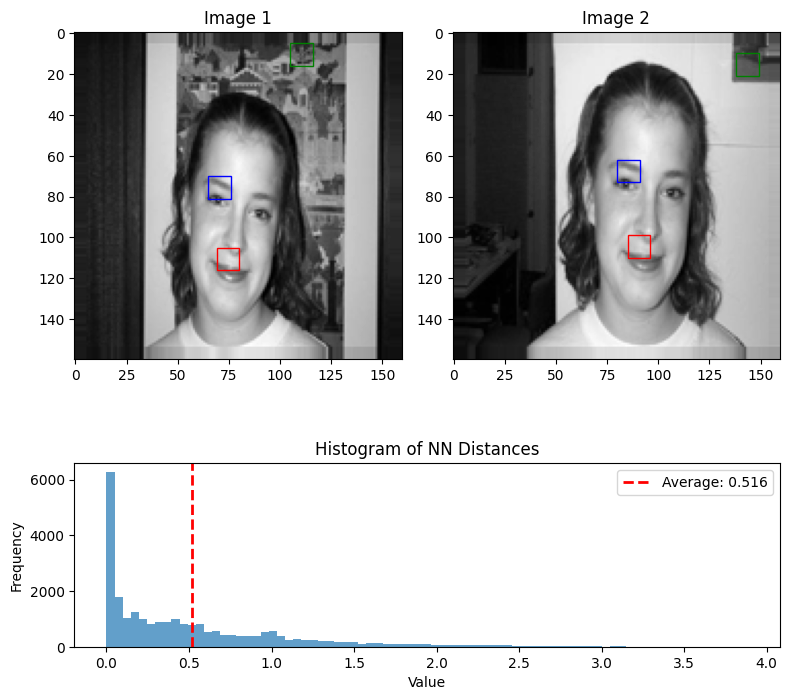

In [430]:
indices = [(110, 74), (10, 110), (75, 70)]

display_patches_with_histogram(
    image1_cropped, image2_cropped,
    indices, [nnf[i, j] for (i, j) in indices],
    PATCH_SIZE, nnf_dist
)